In [1]:
import pandas as pd
import seaborn as sn
from pretty_confusion_matrix import pp_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Reseau:
    def __init__(self, structure):
        self.structure = structure
        self.num_layers = len(structure)
        self.biais = [np.random.rand(l, 1)*2 - 1 for l in structure[1:]]
        self.poids = [np.random.rand(l, next_l)*2 - 1 for l, next_l in zip(structure[:-1], structure[1:])]
    
    def cout(self,x ,y):
        Z, A = self.propag(x)
        return((A[self.num_layers-2]-y).T@(A[self.num_layers-2]-y))

    def retropropag(self, x, y):
        d_biais = [np.zeros(b.shape) for b in self.biais]
        d_poids = [np.zeros(w.shape) for w in self.poids]

        Z, A = self.propag(x)        
        H = self.num_layers-2
        for L in range(H, -1, -1):
            delta = deriv_activ(Z[L])*(self.poids[L+1] @ delta) if L!=H else 2*(A[L]-y)*deriv_activ(Z[L])
            delta = np.reshape(delta, (len(delta),1))
            d_biais[L] = delta
            d_poids[L] = A[L-1] @ delta.T if L != 0 else x @ delta.T
        
        return(d_biais, d_poids)

    def propag(self, x):
        Z = []
        A = []
        for b, W in zip(self.biais, self.poids):
            z = W.T @ a + b if Z else W.T @ x + b
            a = activ(z)
            Z.append(z)
            A.append(a)
        return(Z, A)

    def SGD(self, mini_batch, learning_rate):
        d_biais_tot = [np.zeros(b.shape) for b in self.biais]
        d_poids_tot = [np.zeros(w.shape) for w in self.poids]

        for x, y in mini_batch:
            d_biais, d_poids = self.retropropag(x, y)
            d_biais_tot = [d_b + d_b_tot for d_b, d_b_tot in zip(d_biais, d_biais_tot)]
            d_poids_tot = [d_w + d_w_tot for d_w, d_w_tot in zip(d_poids, d_poids_tot)]
        d = len(mini_batch)
        self.poids = [W - learning_rate/d * d_p for W, d_p in zip(self.poids, d_poids_tot)]
        self.biais = [b - learning_rate/d * d_b for b, d_b in zip(self.biais, d_biais_tot)]
    
    def train(self, epochs, training_data, learning_rate):
        for j in range(epochs):
            for mini_batch in training_data:
                self.SGD(mini_batch, learning_rate)
            print("Epoch Done")


def activ(z):
    return 1.0/(1.0+np.exp(-1.0*z))
    # return(z)
    
def deriv_activ(z):
    return activ(z)*(1-activ(z))
    # return(z)

In [3]:
def create_batches(input_train, output_train_class_onehot, batch_size):
    indexes_list = np.array(range(len(input_train)))
    np.random.shuffle(indexes_list)
    input_shuffle = input_train[indexes_list]
    output_shuffle = output_train_class_onehot[indexes_list]

    input_batch = []
    output_batch = []
    for i in range(len(input_train)//batch_size):
        input_batch.append(input_shuffle[i*batch_size:(i+1)*batch_size,:])
        output_batch.append(output_shuffle[i*batch_size:(i+1)*batch_size,:])
    
    print(np.shape(input_batch))    
    return(input_batch, output_batch)

In [4]:
batch_size = 256

mnist = tf.keras.datasets.mnist  # load mnist dataset from tensorflow
(input_train, output_train_class), (input_test, output_test_class) = mnist.load_data()

print('input_train (original): ', input_train.shape)
print('input_test (original): ', input_test.shape)
print('output_train (original): ', output_train_class.shape)
print('output_test (original): ', output_test_class.shape)
print()

input_train = input_train / 255.0  # max normalise the image data[0:1]
input_test = input_test / 255.0

output_class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']    # class names string
output_train_class_onehot = tf.keras.utils.to_categorical(output_train_class, 10)  # create one-hot encoded class
output_test_class_onehot = tf.keras.utils.to_categorical(output_test_class, 10)


# Test to print one sample
item_id = 5
print('item_id : ', item_id)
print('output_train_class [item_id] : ', output_train_class[item_id])
print('output_train_class_onehot [item_id] : ', output_train_class_onehot[item_id, :])

#plt.imshow(input_train[item_id, :, :], cmap=plt.cm.binary)
#plt.title('input_train [' + str(item_id) + ']')

## Reshape the input to flatten it
input_train = np.reshape(input_train,(len(input_train), 28*28, 1))
input_test = np.reshape(input_test,(len(input_test), 28*28, 1))
output_train_class_onehot = np.reshape(output_train_class_onehot,(len(output_train_class_onehot), 10, 1))
output_test_class_onehot = np.reshape(output_test_class_onehot,(len(output_test_class_onehot), 10, 1))
print('input_train (reshape): ', input_train.shape)
print('input_test (reshape): ', input_test.shape)
print('output_train (onehot): ', output_train_class_onehot.shape)
print('output_test (onehot): ', output_test_class_onehot.shape)

input_batches_train, output_batches_train = create_batches(input_train, output_train_class_onehot, batch_size)

#####################################################################
####            Define and train the network                     ####
#####################################################################

my_net = Reseau([len(input_test[0]), 256 ,len(output_train_class_onehot[0])])
print("Network defined")

training_data = [[(i,o) for i,o in zip(input_batches_train[b], output_batches_train[b])] for b in range(len(input_batches_train))]


input_train (original):  (60000, 28, 28)
input_test (original):  (10000, 28, 28)
output_train (original):  (60000,)
output_test (original):  (10000,)

item_id :  5
output_train_class [item_id] :  2
output_train_class_onehot [item_id] :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
input_train (reshape):  (60000, 784, 1)
input_test (reshape):  (10000, 784, 1)
output_train (onehot):  (60000, 10, 1)
output_test (onehot):  (10000, 10, 1)
(234, 256, 784, 1)
Network defined


In [ ]:
# my_net.train(5, training_data, 1.0)
# print("Entrainement termine")

# with open('biais5_full.npy', 'wb') as f:
#     np.save(f, np.array(my_net.biais))

# with open('poids5_full.npy', 'wb') as f:
#     np.save(f, np.array(my_net.poids))

In [15]:
with open('biais5_full.npy', 'rb') as f:
    b = np.load(f, allow_pickle=True)

with open('poids5_full.npy', 'rb') as f:
    p = np.load(f, allow_pickle=True)

my_net.poids = p
my_net.biais = b

item_id :  82
output_train_class [item_id] :  2
output_train_class_onehot [item_id] :  [[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Output from the network is : 
[[0.72826662]
 [0.94334398]
 [0.00180322]
 [0.00401724]
 [0.99152229]
 [0.76307724]
 [0.99445242]
 [0.9997579 ]
 [0.02279164]
 [0.93006135]]


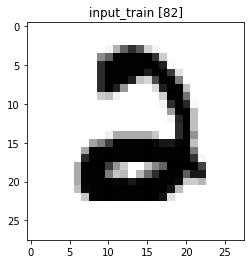

In [5]:
item_id = 82
print('item_id : ', item_id)
print('output_train_class [item_id] : ', output_train_class[item_id])
print('output_train_class_onehot [item_id] : ', output_train_class_onehot[item_id, :])

plt.imshow(np.reshape(input_train[item_id, :, :],(28,28)), cmap=plt.cm.binary)
plt.title('input_train [' + str(item_id) + ']')

Z, A = my_net.propag(np.reshape(input_train[item_id, :, :],(784,1)))

print("Output from the network is : ")
print(A[-1])

In [17]:
def confusion_matrix(input_test, output_test_class_onehot, network):
    matrix_conf = np.zeros((10,10))
    for x, y in zip(input_test, output_test_class_onehot):
        Z, A = network.propag(np.reshape(x,(784,1)))
        prediction = np.argmax(A[-1])
        truth = np.argmax(y)
        matrix_conf[truth, prediction] += 1
    return(matrix_conf)

confusion = confusion_matrix(input_test, output_test_class_onehot, my_net)

[[9.480e+02 0.000e+00 5.000e+00 1.000e+00 0.000e+00 8.000e+00 7.000e+00
  2.000e+00 9.000e+00 0.000e+00]
 [0.000e+00 1.109e+03 4.000e+00 5.000e+00 1.000e+00 1.000e+00 5.000e+00
  1.000e+00 9.000e+00 0.000e+00]
 [9.000e+00 2.000e+00 9.180e+02 1.600e+01 1.200e+01 5.000e+00 1.300e+01
  1.900e+01 3.300e+01 5.000e+00]
 [0.000e+00 1.000e+00 2.400e+01 9.120e+02 4.000e+00 2.500e+01 4.000e+00
  1.000e+01 2.200e+01 8.000e+00]
 [2.000e+00 4.000e+00 3.000e+00 2.000e+00 9.190e+02 2.000e+00 9.000e+00
  6.000e+00 9.000e+00 2.600e+01]
 [2.600e+01 1.200e+01 3.700e+01 8.900e+01 4.700e+01 4.700e+02 2.800e+01
  3.600e+01 9.700e+01 5.000e+01]
 [8.000e+00 3.000e+00 1.300e+01 0.000e+00 1.800e+01 1.000e+01 8.950e+02
  2.000e+00 8.000e+00 1.000e+00]
 [6.000e+00 1.100e+01 2.700e+01 8.000e+00 9.000e+00 7.000e+00 1.000e+00
  9.400e+02 8.000e+00 1.100e+01]
 [6.000e+00 3.000e+00 1.200e+01 2.400e+01 1.700e+01 2.700e+01 8.000e+00
  1.400e+01 8.490e+02 1.400e+01]
 [9.000e+00 9.000e+00 9.000e+00 1.500e+01 1.110e+02 1.7

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


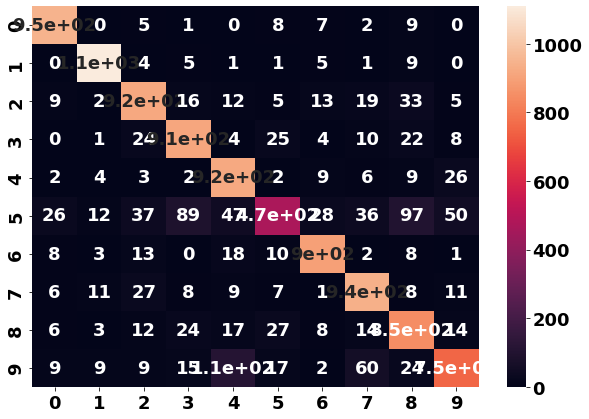

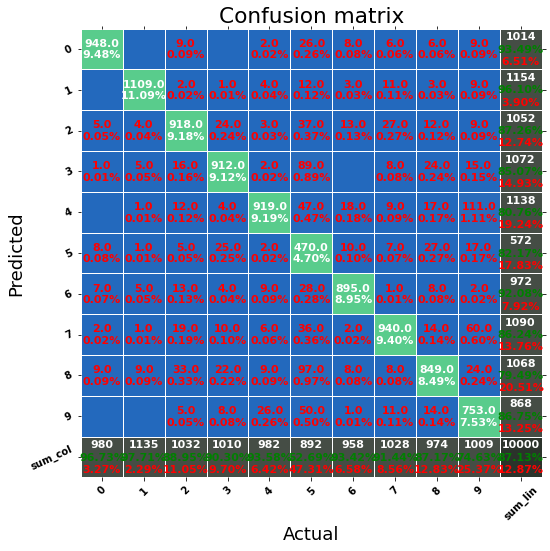

In [18]:
print(confusion)
df_cm = pd.DataFrame(confusion, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# get pandas dataframe
df_cm = pd.DataFrame(confusion, index=range(10), columns=range(10))
# colormap: see this and choose your more dear
cmap = 'vlag'
pp_matrix(df_cm, cmap=cmap)

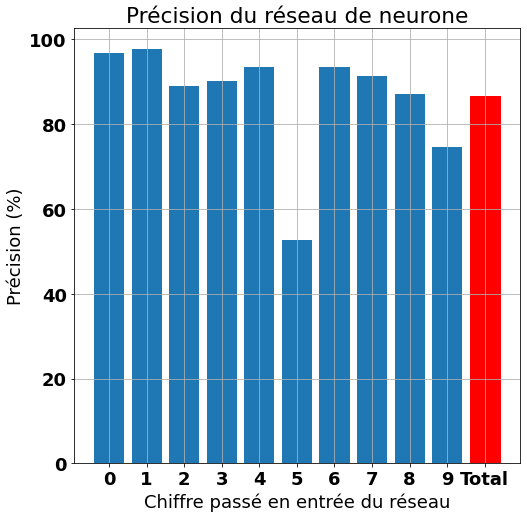

In [19]:
#### Print accuracy for all digits
import matplotlib 

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

n_actual = np.sum(confusion, axis=1)
n_true = np.array([confusion[i][i] for i in range(10)])

accuracy = n_true/n_actual*100
overall_acc = np.mean(accuracy)
labels_number = [str(i) for i in range(10)]

fig, ax = plt.subplots(figsize=(8,8))
#plt.bar([i for i in range(10)], accuracy)
hbars = ax.bar([i for i in range(11)], np.concatenate((accuracy, [overall_acc])), align='center')
hbars[10].set_color('r')
ax.set_xticks([i for i in range(11)])
ax.set_xticklabels(np.concatenate((labels_number,["Total"])))
ax.grid()
ax.set_xlabel("Chiffre passé en entrée du réseau")
ax.set_ylabel("Précision (%)")
ax.set_title("Précision du réseau de neurone")
plt.show()

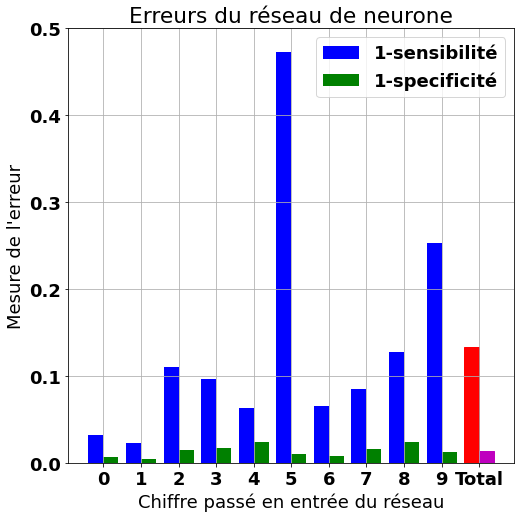

In [20]:
## Calcul des différents type d'erreur
n_actual = np.sum(confusion, axis=1)
n_true = np.array([confusion[i][i] for i in range(10)])
n_predicted = np.sum(confusion, axis=0)
n_total = np.sum(n_actual)
n_total_mat = [n_total for i in range(10)]

FP = n_predicted - n_true
FN = n_actual - n_true
TP = n_true
TN = n_total_mat - FP - FN - TP

sensi = TP/(TP+FN)
speci = TN/(TN+FP)
m1_sensi = 1-sensi
m1_speci = 1-speci

overall_sensi = np.mean(m1_sensi)
overall_speci = np.mean(m1_speci)

x_loc = np.array([i for i in range(11)])

fig, ax = plt.subplots(figsize=(8,8))
bar_FP = ax.bar(x_loc-0.2, np.concatenate((m1_sensi, [overall_sensi])), width=0.4, color='b', align='center')
bar_FN = ax.bar(x_loc+0.2, np.concatenate((m1_speci, [overall_speci])), width=0.4, color='g', align='center')

ax.legend( (bar_FP[0], bar_FN[0]), ('1-sensibilité', '1-specificité'))

bar_FP[10].set_color('r')
bar_FN[10].set_color('m')

ax.set_xticks([i for i in range(11)])
ax.set_xticklabels(np.concatenate((labels_number,["Total"])))
ax.grid()
ax.set_xlabel("Chiffre passé en entrée du réseau")
ax.set_ylabel("Mesure de l'erreur")
ax.set_title("Erreurs du réseau de neurone")
ax.set_ylim((0,0.5))
plt.show()